# Abc about tensorflow
Symbolic math "language"
You write z = x + y 

and then compile(z)

and then compute z for x=4, y=7


In [1]:
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

z = x+y

result = sess.run([z],feed_dict={x:[4],y:[7]})
print(result)

[array([ 11.], dtype=float32)]


# Why not compute them directly?
Because we can compile them for CUDA, for CPU, or on N CUDA + M CPUs, etc.

We need to build a compute graph that will be compiled by the (nv|g)cc compiler. So you write python but execute C.

# Let's classify sth! First, get the dataset:

Using TensorFlow backend.


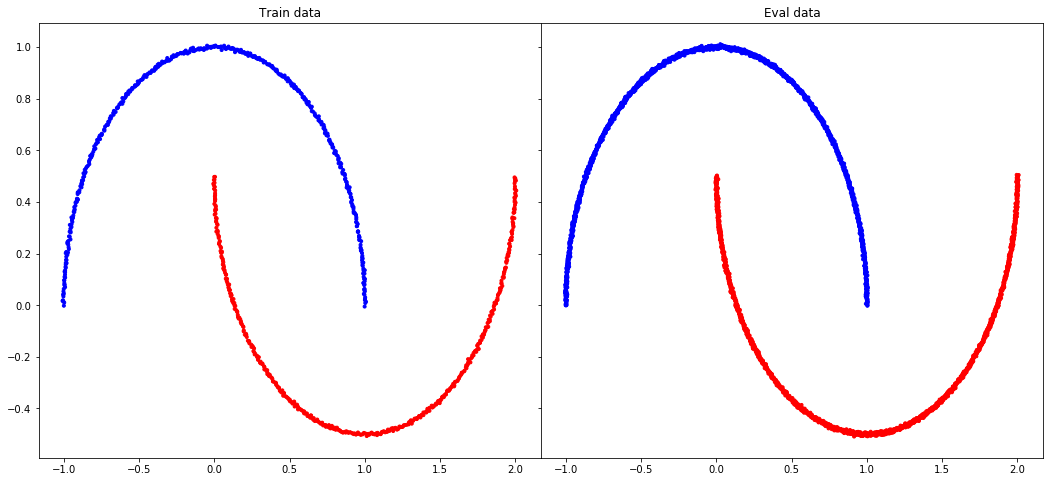

In [2]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from matplotlib.colors import ListedColormap
import sklearn.datasets
import keras.layers as l
import keras.models
from keras.utils.np_utils import to_categorical
import keras.callbacks as callbacks
import shutil
import sklearn.metrics as skm
import os

col2 = ListedColormap(['#0000FF', '#FF0000'])

def plot_data(X,Y,ax=None,title=None):
    """
    Utility func to plot points
    """
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
    ax.scatter(X[:,0],X[:,1],c=Y,cmap=col2,marker='.',linewidths=1,alpha=1)
    if title is not None:
        ax.set_title(title)
    if ax is None:
        plt.show(fig)

def plot_decbounds(X,model,ax):
    """
    Utility func to plot decision boundaries
    """
    x1,x2=np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]+0.05),0.05),np.arange(np.min(X[:,1]),np.max(X[:,1]+0.05),0.05))
    xd = np.stack([x1.ravel(),x2.ravel()],axis=1)
    yd = model.predict(xd)
#     yd = yd[:,1]
    yd = yd.reshape(x1.shape)
    ax.contourf(x1,x2,yd,cmap=col2,alpha=0.3,levels=np.linspace(0,1,17))


def from_preds_to_labels(preds):
#     pred_class = np.argmax(preds,axis=1)    
    pred_class = (preds >= 0.5).astype(np.uint8)
    return pred_class
    
def eval_perf(gt,pred_proba,msg):
    preds = from_preds_to_labels(pred_proba)
    acc = skm.accuracy_score(gt,preds)
    log = skm.log_loss(gt,pred_proba)
    print("{}: accuracy: {:.2f}, log-loss: {:.5f}".format(msg,acc * 100,log))
    return acc,log

def plot_learning_curves(tr,te):
    fig = plt.figure(figsize=(18,8))
    fig.gca().plot(tr,label="train")
    fig.gca().plot(te,label="test")
    plt.legend()
    fig.show()

NOISE_LEVEL = 0.0038  # 0.38    
    
X,Y = sklearn.datasets.make_moons(1000, shuffle=True, noise = NOISE_LEVEL)
Xt,Yt = sklearn.datasets.make_moons(4000, shuffle=True, noise = NOISE_LEVEL)
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Eval data")

# Build a 1 neuron NN (that is, a logistic regression, a linear boundary)
https://www.google.ro/search?q=logistic+regression+neuron&source=lnms&tbm=isch&sa=X&ved=0ahUKEwj8nIyPhMzUAhVjCZoKHX_OCjYQ_AUICigB&biw=1855&bih=966

In [3]:
print("\n".join(["{:.4f}\t{:.4f}\t{}".format(X[k,0],X[k,1],Y[k]) for k in range(10)]))

-0.9388	0.3387	0
1.9755	0.2846	1
0.3286	0.9406	0
0.3897	-0.2948	1
-0.6554	0.7491	0
-0.8318	0.5555	0
0.0684	0.1353	1
0.1346	0.0010	1
1.8327	-0.0398	1
1.5795	-0.3133	1


In [4]:
model = keras.models.Sequential()
model.add(l.Dense(1,input_dim=(2)))
model.add(l.Activation('sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
log_train = [];log_test=[]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 3.0
Trainable params: 3.0
Non-trainable params: 0.0
_________________________________________________________________


In [5]:
model.fit(X,Y,batch_size=32,epochs=1,verbose=0)

In [6]:
Ypred = model.predict(Xt)
Ypred1 = from_preds_to_labels(Ypred)
print("Shape of the predicted array: {}".format(Ypred.shape))
print("Prediction  Class")
print("\n".join(["{:.4f}\t{}".format (a[0],b[0]) for (a,b) in zip(Ypred[:10,:],Ypred1[:10])]))
eval_perf(Y,model.predict(X),"Train set")
eval_perf(Yt,model.predict(Xt),"Test set ")

Shape of the predicted array: (4000, 1)
Prediction  Class
0.9079	1
0.8241	1
0.9182	1
0.2761	0
0.3678	0
0.5051	1
0.6315	1
0.5318	1
0.3625	0
0.8600	1
Train set: accuracy: 74.10, log-loss: 0.56753
Test set : accuracy: 74.02, log-loss: 0.56747


(0.74024999999999996, 0.56747470184788107)

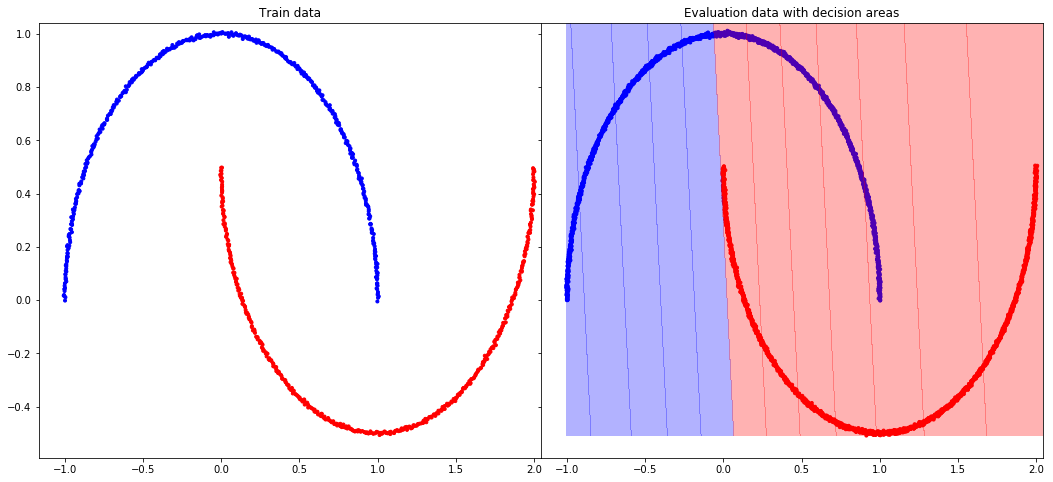

In [7]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Evaluation data with decision areas")
plot_decbounds(Xt,model,ax[1])

Iteration: 0
Train set: accuracy: 70.60, log-loss: 0.49840
Test set : accuracy: 70.70, log-loss: 0.49818
Iteration: 1
Train set: accuracy: 73.30, log-loss: 0.45489
Test set : accuracy: 73.47, log-loss: 0.45452
Iteration: 2
Train set: accuracy: 75.60, log-loss: 0.42464
Test set : accuracy: 75.67, log-loss: 0.42416
Iteration: 3
Train set: accuracy: 77.40, log-loss: 0.40142
Test set : accuracy: 77.50, log-loss: 0.40083
Iteration: 4
Train set: accuracy: 78.80, log-loss: 0.38216
Test set : accuracy: 78.97, log-loss: 0.38148
Iteration: 5
Train set: accuracy: 80.20, log-loss: 0.36551
Test set : accuracy: 80.17, log-loss: 0.36474
Iteration: 6
Train set: accuracy: 81.20, log-loss: 0.35075
Test set : accuracy: 81.27, log-loss: 0.34990
Iteration: 7
Train set: accuracy: 82.20, log-loss: 0.33757
Test set : accuracy: 82.12, log-loss: 0.33665
Iteration: 8
Train set: accuracy: 82.90, log-loss: 0.32580
Test set : accuracy: 83.03, log-loss: 0.32481
Iteration: 9
Train set: accuracy: 83.70, log-loss: 0.31

/home/visoft/miniconda3/envs/col/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


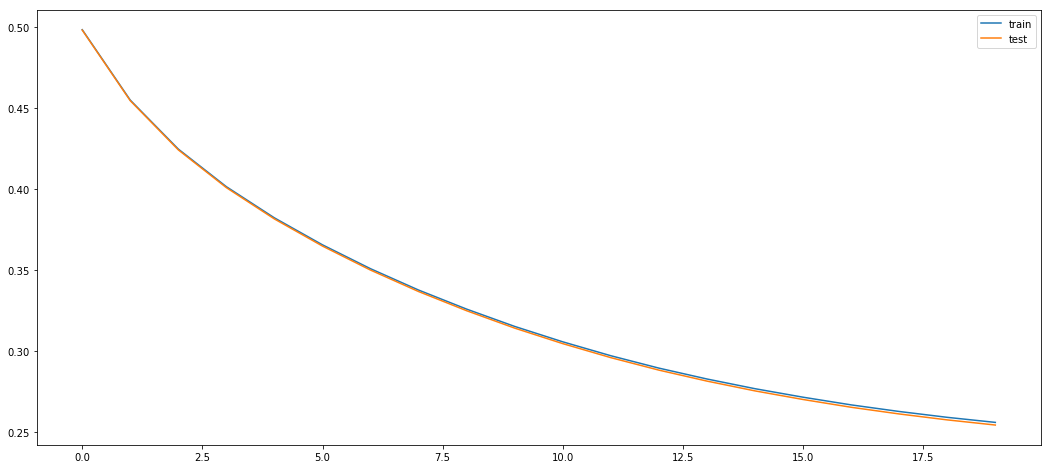

In [8]:
for k in range(20):
    model.fit(X,Y,batch_size=32,epochs=10,verbose=0)
    print("Iteration: {}".format(k))
    _,ll = eval_perf(Y,model.predict(X),"Train set");log_train.append(ll)
    _,ll = eval_perf(Yt,model.predict(Xt),"Test set ");log_test.append(ll)
plot_learning_curves(log_train,log_test)  

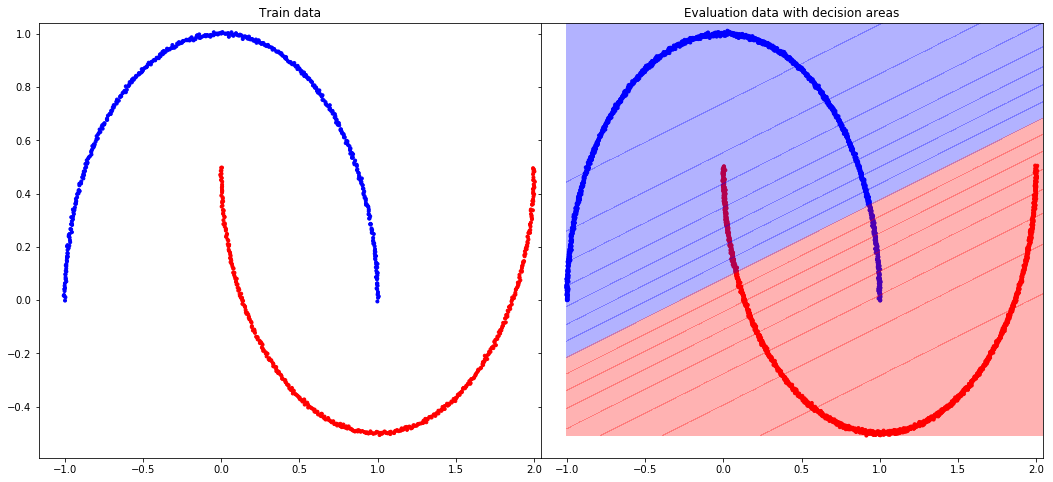

In [9]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data")
plot_data(Xt,Yt,ax[1],"Evaluation data with decision areas")
plot_decbounds(Xt,model,ax[1])
plt.show(fig)

# Ramp things up! More layers! Mwahahaha!
 - go wide
 - go deep
 - go deeper and demo overfitting 
 
https://www.google.ro/search?q=logistic+regression+neuron&source=lnms&tbm=isch&sa=X&ved=0ahUKEwj8nIyPhMzUAhVjCZoKHX_OCjYQ_AUICigB&biw=1855&bih=966#tbm=isch&q=multilayer+perceptron&imgrc=08I2-R9bHBLncM:

In [10]:
model2 = keras.models.Sequential()
model2.add(l.Dense(5,activation='relu',input_dim=2,name="dense_1"))
# model2.add(l.Dense(5,activation='relu',name="dense_2"))
# model2.add(l.Dense(5,activation='relu',name="dense_3"))
# model2.add(l.Dense(5,activation='relu',name="dense_4"))
# model2.add(l.Dense(5,activation='relu',name="dense_5"))
# model2.add(l.Dense(5,activation='relu',name="dense_6"))

model2.add(l.Dense(1,activation='sigmoid',name="sigmoid_layer"))

model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()
log_train = [];log_test=[]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
sigmoid_layer (Dense)        (None, 1)                 6         
Total params: 21.0
Trainable params: 21
Non-trainable params: 0.0
_________________________________________________________________


Iteration: 0
Train set: accuracy: 77.50, log-loss: 0.42423
Test set : accuracy: 77.68, log-loss: 0.42369
Iteration: 1
Train set: accuracy: 82.50, log-loss: 0.34490
Test set : accuracy: 82.58, log-loss: 0.34390
Iteration: 2
Train set: accuracy: 86.50, log-loss: 0.28249
Test set : accuracy: 86.52, log-loss: 0.28112
Iteration: 3
Train set: accuracy: 88.20, log-loss: 0.24548
Test set : accuracy: 88.20, log-loss: 0.24387
Iteration: 4
Train set: accuracy: 89.00, log-loss: 0.22087
Test set : accuracy: 89.25, log-loss: 0.21921
Iteration: 5
Train set: accuracy: 90.40, log-loss: 0.20075
Test set : accuracy: 90.42, log-loss: 0.19912
Iteration: 6
Train set: accuracy: 91.60, log-loss: 0.18218
Test set : accuracy: 91.60, log-loss: 0.18055
Iteration: 7
Train set: accuracy: 92.50, log-loss: 0.16453
Test set : accuracy: 92.62, log-loss: 0.16296
Iteration: 8
Train set: accuracy: 93.70, log-loss: 0.14729
Test set : accuracy: 93.75, log-loss: 0.14584
Iteration: 9
Train set: accuracy: 94.50, log-loss: 0.13

/home/visoft/miniconda3/envs/col/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


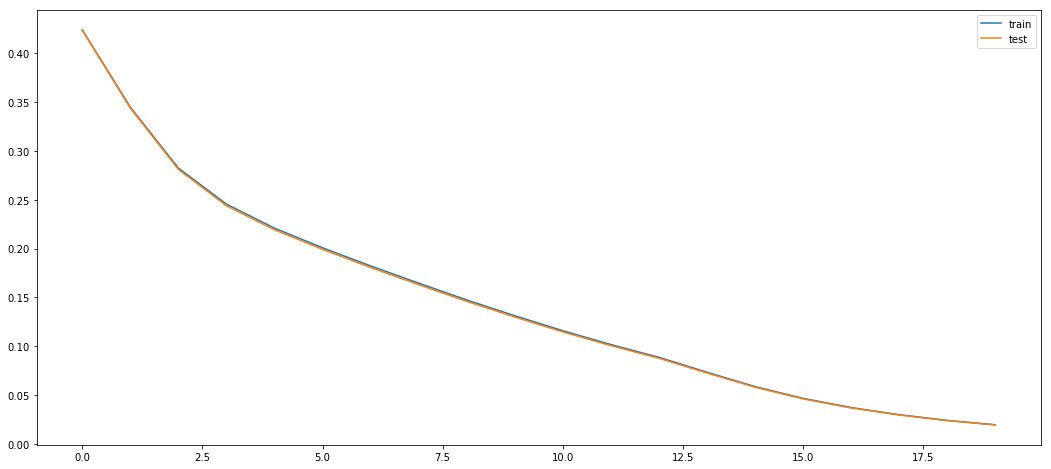

In [11]:
for k in range(20):
    model2.fit(X,Y,batch_size=32,epochs=10,verbose=0)
    print("Iteration: {}".format(k))
    _,ll = eval_perf(Y,model2.predict(X),"Train set");log_train.append(ll)
    _,ll = eval_perf(Yt,model2.predict(Xt),"Test set ");log_test.append(ll)
plot_learning_curves(log_train,log_test)    

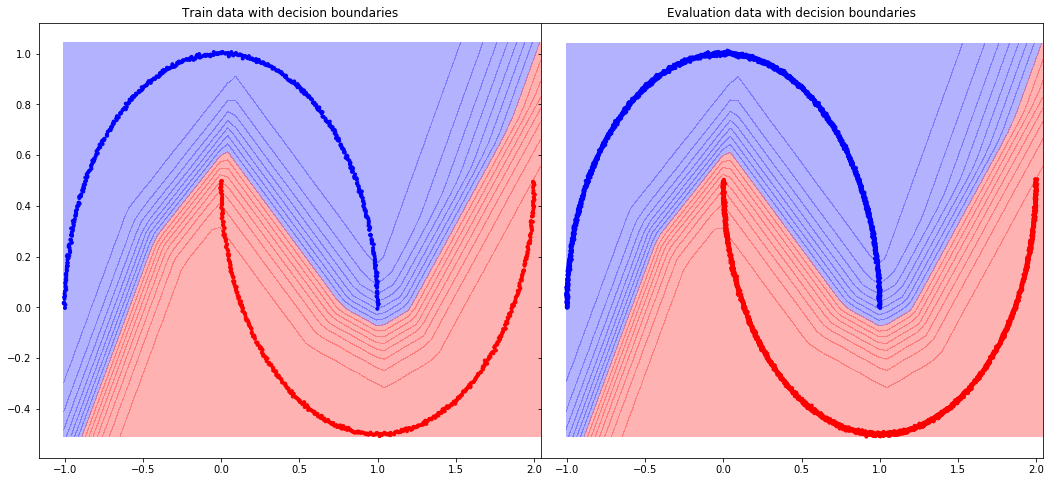

In [12]:
Ypred3 = from_preds_to_labels(model2.predict(X))
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=2,sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
plot_data(X,Y,ax[0],"Train data with decision boundaries")
plot_decbounds(X,model2,ax[0])
plot_data(Xt,Yt,ax[1],"Evaluation data with decision boundaries")
plot_decbounds(Xt,model2,ax[1])
plt.show(fig)

## How neural nets deal with imbalanced datasets (question from the public)
For regular classifiers I used class weights (when possible) or directly instance weights. Unfortunately, I didn't work extensively with these kind of problems recently (in DL context). 

Reading the docs you can find some sort of [class weight](https://keras.io/models/model/) for the losses. Quote:

    model.compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None)
    ....
    loss_weights: Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. If a list, it is expected to have a 1:1 mapping to the model's outputs. If a tensor, it is expected to map output names (strings) to scalar coefficients.
    
In theory it should work as the sklearn's ```class_weight``` parameter. If the loss for a certain point is higher, will propagate a higher gradient.

Another option (that I took on a small project) was heavy data augmentation for the poorly represented class. It didn't work so well because at prediction time you still have this imbalance.

Hope it helps and feel free to come up witn an example!


## Create conda env and install tensorflow
    
    I will give you some instructions on how to install tensorflow and keras on your system. This worked on my ubuntu several months ago. I hope that it will work for another few months. Ping me if there are errors or make a pull request with updated settings.
    
###  Install miniconda, ver 4.3.11
    
    https://conda.io/docs/install/quick.html
    
###  Create an env for tensorflow:
    
    conda create -y -n tf --copy python=3.5 numpy scipy scikit-learn scikit-image opencv pytest h5py joblib matplotlib jupyter pip
    source activate tf
    export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-1.0.1-cp35-cp35m-linux_x86_64.whl
    pip install $TF_BINARY_URL
    pip install keras==2.0.2

### Clone the repo and go into its root folder

### Start notebook 

    jupyter notebook
    
### Start tensorboard (optional, not used here)
    
    tensorboard --logdir=tb_log --reload_interval 1
    
## Resources to learn stuff:
 - http://www.fast.ai/  Take fast.ai MOOC. Really awesome! Deep learning in Excel! (no joking) I would start with this one!
 - https://www.deeplearningbook.org/  To make sure that you know what is established and what is still debatable in deep learning. You don't need more than Section 2 to be a good practitioner.
 - http://neuralnetworksanddeeplearning.com/ Nice and smooth start. A little to much math.
 - Coursera and Udacity lectures
 - For specific tutorials and datasets, take a look at past Kaggle competitions.
 - http://deeplearning.net/ Collection of resources, slightly outdated but still relevant